<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras

Aguirregaray, Mauro

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [100]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import gdown
from google.colab import files

### Datos
Para este desafío mantendré el mismo libro que utilicé en el desafío 2 "Wind Energy Handbook".

In [101]:
# Descargamos el archivo de mi google Drive
file_id = '1RRYQpckyJFtrE1Me2GRxkQuw3xp1zZpp'  
destination = 'Wind_Energy_Handbook.pdf'  


gdown.download(id=file_id, output=destination, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1RRYQpckyJFtrE1Me2GRxkQuw3xp1zZpp
To: /content/Wind_Energy_Handbook.pdf
100%|██████████| 5.12M/5.12M [00:00<00:00, 28.4MB/s]


'Wind_Energy_Handbook.pdf'

Para poder sacar la información del pdf utilizamos la librería pymupdf.

In [102]:
# Usamos la libreria pymupdf
!pip install pymupdf

In [103]:
import fitz  # PyMuPDF se importa como 'fitz'

# Ruta del archivo PDF
pdf_path = 'Wind_Energy_Handbook.pdf'

# Abre el archivo PDF
doc = fitz.open(pdf_path)

# Extrae el texto de todas las páginas
text = ""
for page_num in range(len(doc)):
    page = doc.load_page(page_num)  # Carga una página
    text += page.get_text()  # Extrae el texto de la página

doc.close()

# Muestra el texto extraído
print(text)

# Convierte el texto en una lista de palabras
words = text.split()  # Divide el texto en palabras usando los espacios

# Muestra la lista de palabras
print("Palabras extraídas:")
print(words)

WIND ENERGY
HANDBOOK
WIND ENERGY
HANDBOOK
Tony Burton
Wind Energy Consultant, Carno, UK
David Sharpe
CREST, Loughborough University, UK
Nick Jenkins
UMIST, Manchester, UK
Ervin Bossanyi
Garrad Hassan & Partners, Bristol, UK
JOHN WILEY & SONS, LTD
Chichester • New York • Weinheim • Brisbane • Singapore • Toronto
Copyright # 2001 by John Wiley & Sons, Ltd
Bafﬁns Lane, Chichester
West Sussex, PO19 1UD, England
National
01243 779777
International (þ44) 1243 779777
e-mail (for orders and customer service enquiries): cs-books@wiley.co.uk
Visit our Home Page on: http://www.wiley.co.uk or http://www.wiley.com
All Rights Reserved. No part of this publication may be reproduced, stored in a retrieval system, or
transmitted, in any form or by any means, electronic, mechanical, photocopying, recording, scanning or
otherwise, except under the terms of the Copyright Designs and Patents Act 1988 or under the terms of a
licence issued by the Copyright Licensing Agency, 90 Tottenham Court Road, London, 

In [104]:
words.__len__()

228327

De esta manera tenemos todo el texto y todas las palabras divididas por un espacio.

Ahora tenemos que elegir el tamaño del contexto.


### Elegir el tamaño del contexto

In [105]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


A diferencia de lo que se planteo en clase que estaba separado por versos, necesitamos poder ordenar oraciones en este caso. Para eso vamos a usar la puntuación presente en el documento.

In [106]:
import nltk

# Asegúrate de descargar los datos de puntuación para dividir oraciones
nltk.download('punkt')

# Segmentamos el texto en oraciones
sentences = nltk.sent_tokenize(text)  # Usamos NLTK para dividir el texto en oraciones

# Aplicamos 'text_to_word_sequence' para cada oración segmentada
segmented_sentences = [text_to_word_sequence(sentence) for sentence in sentences]

# Muestra las oraciones segmentadas y tokenizadas
print(segmented_sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[['wind', 'energy', 'handbook', 'wind', 'energy', 'handbook', 'tony', 'burton', 'wind', 'energy', 'consultant', 'carno', 'uk', 'david', 'sharpe', 'crest', 'loughborough', 'university', 'uk', 'nick', 'jenkins', 'umist', 'manchester', 'uk', 'ervin', 'bossanyi', 'garrad', 'hassan', 'partners', 'bristol', 'uk', 'john', 'wiley', 'sons', 'ltd', 'chichester', '•', 'new', 'york', '•', 'weinheim', '•', 'brisbane', '•', 'singapore', '•', 'toronto', 'copyright', '2001', 'by', 'john', 'wiley', 'sons', 'ltd', 'bafﬁns', 'lane', 'chichester', 'west', 'sussex', 'po19', '1ud', 'england', 'national', '01243', '779777', 'international', 'þ44', '1243', '779777', 'e', 'mail', 'for', 'orders', 'and', 'customer', 'service', 'enquiries', 'cs', 'books', 'wiley', 'co', 'uk', 'visit', 'our', 'home', 'page', 'on', 'http', 'www', 'wiley', 'co', 'uk', 'or', 'http', 'www', 'wiley', 'com', 'all', 'rights', 'reserved'], ['no', 'part', 'of', 'this', 'publication', 'may', 'be', 'reproduced', 'stored', 'in', 'a', 'retrie

In [107]:
segmented_sentences

[['wind',
  'energy',
  'handbook',
  'wind',
  'energy',
  'handbook',
  'tony',
  'burton',
  'wind',
  'energy',
  'consultant',
  'carno',
  'uk',
  'david',
  'sharpe',
  'crest',
  'loughborough',
  'university',
  'uk',
  'nick',
  'jenkins',
  'umist',
  'manchester',
  'uk',
  'ervin',
  'bossanyi',
  'garrad',
  'hassan',
  'partners',
  'bristol',
  'uk',
  'john',
  'wiley',
  'sons',
  'ltd',
  'chichester',
  '•',
  'new',
  'york',
  '•',
  'weinheim',
  '•',
  'brisbane',
  '•',
  'singapore',
  '•',
  'toronto',
  'copyright',
  '2001',
  'by',
  'john',
  'wiley',
  'sons',
  'ltd',
  'bafﬁns',
  'lane',
  'chichester',
  'west',
  'sussex',
  'po19',
  '1ud',
  'england',
  'national',
  '01243',
  '779777',
  'international',
  'þ44',
  '1243',
  '779777',
  'e',
  'mail',
  'for',
  'orders',
  'and',
  'customer',
  'service',
  'enquiries',
  'cs',
  'books',
  'wiley',
  'co',
  'uk',
  'visit',
  'our',
  'home',
  'page',
  'on',
  'http',
  'www',
  'wiley',


Con las oraciones separadas podemos medir de que tamaño son, es decir cuantas palabras contienen esas oraciones.

In [108]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([7.417e+03, 3.200e+01, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([   0. ,  200.1,  400.2,  600.3,  800.4, 1000.5, 1200.6, 1400.7,
        1600.8, 1800.9, 2001. , 2201.1, 2401.2, 2601.3, 2801.4, 3001.5,
        3201.6, 3401.7, 3601.8, 3801.9, 4002. ]),
 <BarContainer object of 20 artists>)

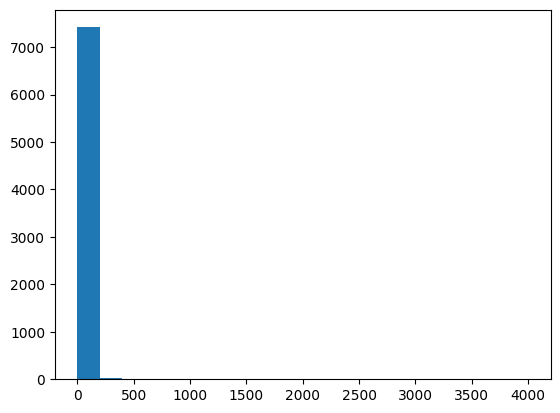

In [109]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

Podemos observar que existen algunas oraciones de un tamaño muy superior al resto, a tal punto que podemos tomarlos como outliers y quitarlas del dataset de estudio.

In [110]:
# Filtra las oraciones que tienen 100 palabras o menos
filtered_sentences = [sentence for sentence in segmented_sentences if len(sentence) <= 100]

# Calcula la longitud de cada secuencia en las oraciones filtradas
length_sentences = [len(sentence) for sentence in filtered_sentences]

# Muestra las oraciones filtradas y sus longitudes
print("Oraciones filtradas:", filtered_sentences)
print("Longitudes de oraciones filtradas:", length_sentences)


Oraciones filtradas: [['wind', 'energy', 'handbook', 'wind', 'energy', 'handbook', 'tony', 'burton', 'wind', 'energy', 'consultant', 'carno', 'uk', 'david', 'sharpe', 'crest', 'loughborough', 'university', 'uk', 'nick', 'jenkins', 'umist', 'manchester', 'uk', 'ervin', 'bossanyi', 'garrad', 'hassan', 'partners', 'bristol', 'uk', 'john', 'wiley', 'sons', 'ltd', 'chichester', '•', 'new', 'york', '•', 'weinheim', '•', 'brisbane', '•', 'singapore', '•', 'toronto', 'copyright', '2001', 'by', 'john', 'wiley', 'sons', 'ltd', 'bafﬁns', 'lane', 'chichester', 'west', 'sussex', 'po19', '1ud', 'england', 'national', '01243', '779777', 'international', 'þ44', '1243', '779777', 'e', 'mail', 'for', 'orders', 'and', 'customer', 'service', 'enquiries', 'cs', 'books', 'wiley', 'co', 'uk', 'visit', 'our', 'home', 'page', 'on', 'http', 'www', 'wiley', 'co', 'uk', 'or', 'http', 'www', 'wiley', 'com', 'all', 'rights', 'reserved'], ['no', 'part', 'of', 'this', 'publication', 'may', 'be', 'reproduced', 'stored

(array([510., 607., 640., 875., 957., 929., 764., 620., 375., 236., 171.,
        108.,  98.,  75.,  57.,  33.,  37.,  33.,  37.,  39.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

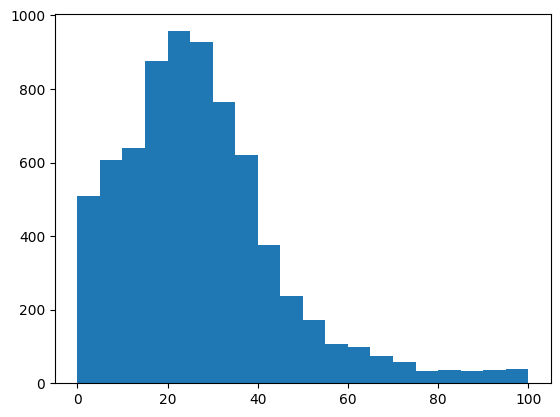

In [111]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

De esta manera si parece ser mucho más representativo el estudio.

In [112]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
# max_context_size = int(np.percentile(length_sentences, 90)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 25


En este caso utilicé el criterio de la mediana para elegir el max_context_size que parece ser más adecuado para un libro de texto a la hora de armar una idea.

###  Tokenizar

In [113]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [114]:
tokenized_sentences[0]

[8,
 58,
 4582,
 8,
 58,
 4582,
 4583,
 3501,
 8,
 58,
 5510,
 7205,
 236,
 4584,
 7206,
 7207,
 7208,
 1772,
 236,
 7209,
 1773,
 7210,
 7211,
 236,
 7212,
 1325,
 2605,
 2606,
 5511,
 4585,
 236,
 1424,
 1211,
 1543,
 1477,
 3502,
 129,
 564,
 1071,
 129,
 5512,
 129,
 7213,
 129,
 3503,
 129,
 7214,
 2849,
 2262,
 18,
 1424,
 1211,
 1543,
 1477,
 7215,
 7216,
 3502,
 7217,
 7218,
 7219,
 7220,
 4586,
 580,
 7221,
 5513,
 734,
 5514,
 7222,
 5513,
 116,
 7223,
 9,
 5515,
 5,
 2607,
 2608,
 7224,
 7225,
 4587,
 1211,
 667,
 236,
 7226,
 5516,
 7227,
 7228,
 23,
 5517,
 1326,
 1211,
 667,
 236,
 44,
 5517,
 1326,
 1211,
 1977,
 197,
 5518,
 7229]

In [115]:
segmented_sentences[0]

['wind',
 'energy',
 'handbook',
 'wind',
 'energy',
 'handbook',
 'tony',
 'burton',
 'wind',
 'energy',
 'consultant',
 'carno',
 'uk',
 'david',
 'sharpe',
 'crest',
 'loughborough',
 'university',
 'uk',
 'nick',
 'jenkins',
 'umist',
 'manchester',
 'uk',
 'ervin',
 'bossanyi',
 'garrad',
 'hassan',
 'partners',
 'bristol',
 'uk',
 'john',
 'wiley',
 'sons',
 'ltd',
 'chichester',
 '•',
 'new',
 'york',
 '•',
 'weinheim',
 '•',
 'brisbane',
 '•',
 'singapore',
 '•',
 'toronto',
 'copyright',
 '2001',
 'by',
 'john',
 'wiley',
 'sons',
 'ltd',
 'bafﬁns',
 'lane',
 'chichester',
 'west',
 'sussex',
 'po19',
 '1ud',
 'england',
 'national',
 '01243',
 '779777',
 'international',
 'þ44',
 '1243',
 '779777',
 'e',
 'mail',
 'for',
 'orders',
 'and',
 'customer',
 'service',
 'enquiries',
 'cs',
 'books',
 'wiley',
 'co',
 'uk',
 'visit',
 'our',
 'home',
 'page',
 'on',
 'http',
 'www',
 'wiley',
 'co',
 'uk',
 'or',
 'http',
 'www',
 'wiley',
 'com',
 'all',
 'rights',
 'reserved']

In [116]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

11535

El tamaño del vocabulario es muy grande y luego tendré problemas de uso de memoria en GPU, por lo que tengo que reducirlo quedandome con las palabras más frecuentes.

In [117]:
from collections import Counter

# Cuenta la frecuencia de todas las palabras en los textos tokenizados
word_freq = Counter([word for sentence in tokenized_sentences for word in sentence])

# Define un umbral de frecuencia (e.g., palabras que aparecen menos de 5 veces)
min_freq = 6
reduced_vocab = {word for word, freq in word_freq.items() if freq >= min_freq}

# Crear un nuevo tokenizador con el vocabulario reducido
reduced_vocab_size = len(reduced_vocab)
word_to_index = {word: i+1 for i, word in enumerate(reduced_vocab)}  # Mapear palabras a índices
index_to_word = {i: word for word, i in word_to_index.items()}  # Inverso para decodificar

# Tokeniza las oraciones de nuevo usando solo el vocabulario reducido
tokenized_sentences_reduced = [[word_to_index[word] for word in sentence if word in reduced_vocab]
                               for sentence in tokenized_sentences]


In [118]:
print("Tamaño del vocabulario reducido:", len(word_to_index))


Tamaño del vocabulario reducido: 3500


In [119]:
# Definir el límite del vocabulario
max_vocab_size = 1000

# Obtener las `max_vocab_size` palabras más comunes
most_common_words = word_freq.most_common(max_vocab_size)
reduced_vocab = {word for word, freq in most_common_words}

# Crear el nuevo diccionario de índices
word_to_index = {word: i+1 for i, word in enumerate(reduced_vocab)}
index_to_word = {i: word for word, i in word_to_index.items()}

# Tokenizar nuevamente con el vocabulario reducido
tokenized_sentences_reduced = [[word_to_index[word] for word in sentence if word in reduced_vocab]
                               for sentence in tokenized_sentences]

In [120]:
print("Tamaño del vocabulario reducido:", len(word_to_index))


Tamaño del vocabulario reducido: 1000


Lo termino dejando en tan solo 1000 palabras diferentes para poder manejar el espacio en memoria de GPU.

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [121]:
tokenized_sentences_train, tokenized_sentences_val = train_test_split(tokenized_sentences_reduced, test_size=0.2, random_state=42)

Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Mantenemos esta idea ya que el tamaño de contexto máximo no es muy grande.

In [122]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [123]:
len(tok_sent)

53347

In [124]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [125]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)
# train_seqs = np.concatenate(tok_sent, axis=0)

In [126]:
train_seqs.shape

(1286192, 26)

In [127]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [128]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'of',
 3: 'to',
 4: 'is',
 5: 'and',
 6: 'a',
 7: 'in',
 8: 'wind',
 9: 'for',
 10: '1',
 11: 'be',
 12: '0',
 13: '3',
 14: '2',
 15: 'speed',
 16: 'as',
 17: '¼',
 18: 'by',
 19: 'at',
 20: 'with',
 21: 'blade',
 22: '5',
 23: 'on',
 24: 'are',
 25: 'r',
 26: 'that',
 27: 'power',
 28: 'which',
 29: 'it',
 30: 'this',
 31: 'm',
 32: '4',
 33: 'from',
 34: 'rotor',
 35: '\x01',
 36: 'turbine',
 37: 'figure',
 38: 'þ',
 39: '6',
 40: '7',
 41: 'can',
 42: 'an',
 43: '10',
 44: 'or',
 45: 'will',
 46: 'u',
 47: 's',
 48: 'design',
 49: '8',
 50: 'so',
 51: 'turbines',
 52: 'moment',
 53: 'pitch',
 54: 'n',
 55: 'tower',
 56: 'frequency',
 57: 'ﬂow',
 58: 'energy',
 59: 'not',
 60: '\x02',
 61: 'loads',
 62: 'but',
 63: 'tip',
 64: 'angle',
 65: 'equation',
 66: 'may',
 67: 'if',
 68: 'control',
 69: 'p',
 70: 'velocity',
 71: 'where',
 72: 't',
 73: '9',
 74: 'c',
 75: 'bending',
 76: 'torque',
 77: 'axis',
 78: 'pressure',
 79: 'load',
 80: 'two',
 81: 'plane',
 82: 'bla

In [129]:
tokenized_sentences_reduced


[[8,
  58,
  8,
  58,
  8,
  58,
  236,
  236,
  236,
  236,
  129,
  564,
  129,
  129,
  129,
  129,
  18,
  580,
  734,
  116,
  9,
  5,
  667,
  236,
  23,
  667,
  236,
  44,
  197],
 [179,
  413,
  2,
  30,
  66,
  11,
  999,
  7,
  6,
  97,
  44,
  7,
  218,
  358,
  44,
  18,
  218,
  340,
  388,
  44,
  411,
  1,
  291,
  2,
  1,
  1000,
  5,
  44,
  411,
  1,
  291,
  2,
  6,
  18,
  1,
  617,
  236,
  516,
  1,
  820,
  7,
  2,
  1,
  20,
  1,
  2,
  218,
  479,
  9,
  1,
  2,
  361,
  5,
  23,
  6,
  97,
  9,
  162,
  18,
  1,
  2,
  1],
 [1,
  218,
  44,
  9,
  238,
  44,
  429,
  3,
  218,
  44,
  259,
  175,
  1,
  479,
  414,
  44,
  44,
  943,
  44,
  33,
  943,
  16,
  6,
  256,
  2,
  167,
  162],
 [1, 5, 197, 498, 2, 9, 218, 335],
 [86, 45, 11, 179, 23, 1, 2, 3, 218, 44, 7, 1],
 [108, 18, 3, 398, 24, 359, 16],
 [7, 197, 71, 4, 2, 6, 1, 7, 753, 44],
 [119, 171, 921, 1, 524, 9, 117, 5],
 [168, 564, 693, 13, 133, 399, 600, 14, 389, 879, 2, 7, 292, 2, 8, 58],
 [],
 [],


In [96]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'of': 2, 'to': 3, 'is': 4, 'and': 5, 'a': 6, 'in': 7, 'wind': 8, 'for': 9, '1': 10, 'be': 11, '0': 12, '3': 13, '2': 14, 'speed': 15, 'as': 16, '¼': 17, 'by': 18, 'at': 19, 'with': 20, 'blade': 21, '5': 22, 'on': 23, 'are': 24, 'r': 25, 'that': 26, 'power': 27, 'which': 28, 'it': 29, 'this': 30, 'm': 31, '4': 32, 'from': 33, 'rotor': 34, '\x01': 35, 'turbine': 36, 'figure': 37, 'þ': 38, '6': 39, '7': 40, 'can': 41, 'an': 42, '10': 43, 'or': 44, 'will': 45, 'u': 46, 's': 47, 'design': 48, '8': 49, 'so': 50, 'turbines': 51, 'moment': 52, 'pitch': 53, 'n': 54, 'tower': 55, 'frequency': 56, 'ﬂow': 57, 'energy': 58, 'not': 59, '\x02': 60, 'loads': 61, 'but': 62, 'tip': 63, 'angle': 64, 'equation': 65, 'may': 66, 'if': 67, 'control': 68, 'p': 69, 'velocity': 70, 'where': 71, 't': 72, '9': 73, 'c': 74, 'bending': 75, 'torque': 76, 'axis': 77, 'pressure': 78, 'load': 79, 'two': 80, 'plane': 81, 'blades': 82, 'disc': 83, 'then': 84, 'ratio': 85, 'there': 86, 'has': 87, 'value': 88, '

In [97]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'01243': 1, 'bossanyi': 21, 'burton': 5, 'http': 1, 'þ44': 2, 'york': 28, 'page': 1, 'wiley': 15, 'ervin': 1, 'manchester': 1, 'weinheim': 2, 'uk': 143, 'sons': 14, 'nick': 1, 'copyright': 5, 'service': 8, 'enquiries': 1, 'cs': 1, 'west': 1, 'home': 1, 'com': 11, 'bafﬁns': 1, 'wind': 1906, 'hassan': 8, 'on': 1148, 'all': 176, 'energy': 395, 'bristol': 3, 'e': 243, 'chichester': 4, 'new': 57, 'toronto': 1, 'consultant': 2, 'national': 56, 'for': 1882, 'crest': 1, 'david': 2, 'customer': 8, 'books': 2, '1243': 1, 'rights': 2, 'sussex': 1, 'reserved': 1, 'carno': 1, 'handbook': 2, 'by': 1255, 'our': 2, 'ltd': 10, 'or': 517, 'tony': 3, '•': 75, 'co': 34, 'lane': 1, 'po19': 1, 'sharpe': 1, 'www': 17, 'jenkins': 14, 'loughborough': 1, '2001': 10, 'brisbane': 1, 'singapore': 5, 'international': 39, 'and': 3218, 'partners': 2, '1ud': 1, 'umist': 1, 'england': 3, 'orders': 2, 'garrad': 8, '779777': 1, 'visit': 1, 'mail': 1, 'university': 14, 'john': 15, 'form': 97, '


### Definir el modelo

In [130]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=max_vocab_size+1, output_dim=16, input_shape=(None,)))

model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(32, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(max_vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, None, 16)            │          16,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, None, 32)            │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, None, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, None, 32)            │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, None, 1001)          │          33,033 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,641 (248.60 KB)

 Trainable params: 63,641 (248.60 KB)

 Non-trainable params: 0 (0.00 B)

El modelo resulta bastante simple, una capa de embedding con solo 16 dimensiones, dos capas LSTM y una densa al final para poder hacer la predicción. En este caso no logré complejizar o aumentar el tamaño de embeddings ni de vocabulario, sin tener problemas en el uso de memoria de GPU.

Por otro lado, pase a usar adam como optimizador pues rmsprop me estaba dando problemas con el cálculo de la pérdida época a época.

Mantenemos el mismo Callback para calcular la perplexity época a época.

In [131]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model_word.h5")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [132]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
5024/5025 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2894


 mean perplexity: 1491.818367881486 

Saved new model!
5025/5025 ━━━━━━━━━━━━━━━━━━━━ 71s 14ms/step - loss: 3.2892
Epoch 2/20
5024/5025 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4579
 mean perplexity: 1529.9340865900701 

5025/5025 ━━━━━━━━━━━━━━━━━━━━ 69s 11ms/step - loss: 2.4579
Epoch 3/20
5022/5025 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3399
 mean perplexity: 1731.36284243591 

5025/5025 ━━━━━━━━━━━━━━━━━━━━ 55s 11ms/step - loss: 2.3399
Epoch 4/20
5022/5025 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2881
 mean perplexity: 1601.3047589543835 

5025/5025 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - loss: 2.2881
Epoch 5/20
5025/5025 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2547
 mean perplexity: 1620.6632841739483 

5025/5025 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 2.2547
Epoch 6/20
5024/5025 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2319


 mean perplexity: 987.2604601701102 

Saved new model!
5025/5025 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - loss: 2.2319
Epoch 7/20
5025/5025 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2139
 mean perplexity: 1112.9886601569215 

5025/5025 ━━━━━━━━━━━━━━━━━━━━ 55s 11ms/step - loss: 2.2139
Epoch 8/20
5022/5025 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2009
 mean perplexity: 1244.5926174244669 

5025/5025 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 2.2009
Epoch 9/20
5023/5025 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1894
 mean perplexity: 1505.8623273653554 

5025/5025 ━━━━━━━━━━━━━━━━━━━━ 79s 11ms/step - loss: 2.1894
Epoch 10/20
5019/5025 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1812
 mean perplexity: 1758.3237091437384 

5025/5025 ━━━━━━━━━━━━━━━━━━━━ 85s 11ms/step - loss: 2.1812
Epoch 11/20
5021/5025 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1724
 mean perplexity: 1692.6923237460294 

Stopping training...
5025/5025 ━━━━━━━━━━━━━━━━━━━━ 56s 11ms/step - loss: 2.1724


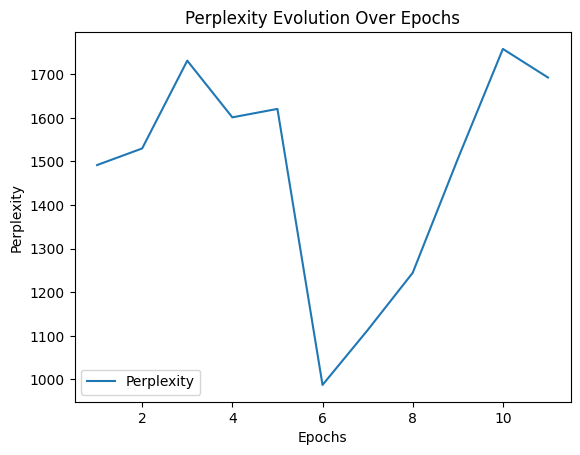

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count, y=history_ppl, label='Perplexity')

# Agregar título y etiquetas
plt.title('Perplexity Evolution')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')

# Mostrar leyenda
plt.legend()

# Mostrar gráfico
plt.show()

In [135]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model_word.h5')

Como era esperable, la perplejidad no evoluciona como sería esperado, sino que parece moverse de manera aleatoria. Esto muy posiblemente se deba a estar usando 10% del total de palabras y que el restante se esté entrenando como una única palabra, a su vez, el modelo tampoco tiene muchos parámetros entrenables y con tan pocas épocas entrenadas el desempeño esperado sería bastante pobre.


### Predicción de próxima palabra

In [136]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/1

In [137]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2a39a5917e157d5def.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

Las inferencias usando la api de gradio se pueden ver en las imágenes dentro de esta carpeta.

### Generación de secuencias

In [138]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [140]:
input_text='wind energy is'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'wind energy is given by ¼ 1 2r\x01 dcl dæ \x01 r ru'

In [141]:
input_text='Atmospheric state impacts energy production'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


'Atmospheric state impacts energy production methods synchronous speed shaft speed gearbox gearbox project upper speed'

In [142]:
input_text='Turbine blades rotate due to the aerodynamic forces generated by wind,'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


'Turbine blades rotate due to the aerodynamic forces generated by wind, speed ﬂuctuations at the rotor disc and the rotor disc'

In [143]:
input_text='Offshore wind farms are gaining popularity due to consistent wind patterns,'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


'Offshore wind farms are gaining popularity due to consistent wind patterns, and the of the of the of the rotor and'

###  Beam search y muestreo aleatorio

In [144]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [145]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [149]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="Turbine blades rotate due to the aerodynamic forces generated by wind,",temp=1,mode='sto')

In [150]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 31)

In [151]:
# veamos las salidas
decode(salidas[0])

['turbine blades rotate due to the aerodynamic forces generated by wind speed in order to the network']

## Conclusiones

Este fue un desafío que realmente me presentó muchas dificultades. Si bien el concepto es muy similar al visto en clase, me enfrenté al problema de que al calcular la perplejidad usando el callback presentado en el notebook de referencia, exigía más memoria en GPU de la disponible en colab y no podía medir la perplejidad.

De acuerdo a este problema, en lugar de buscar otra métrica o usar otras técnicas para medir la perplejidad (por ejemplo las que proporciona tensorflow, que tienen diferencias con las vistas en clase) opté por disminuir el tamaño del modelo para que el entrenamiento planteado sea posible. Esto afectó seriamente el desempeño del modelo.

Sin embargo, y a pesar, de todas las decisiones que impactaron en el desempeño, la predicción de palabras es bastante sorprendente. En las capturas de gradio se puede observar como desarrolla conceptos complejos como "fatigue **loads**", "wind **turbines**" o "mechanical **brake**", siendo quizás el más sorprendente y que más denota el concepto de contexto es "enhanced environmental sutainability over long **term**". En los primeros, la palabra predicha esta directamente relacionada con la anterior, pero en el último para poder predecir un concepto de tiempo tiene que haber entendido el contexto de la frase. Por otro lado, en el caso que uno esperaría que la predicción sea "kinetic **energy**" el modelo no lo logra entender y pone una palabra genérica (en este caso **and**), posiblemente esto se deba a que en el vocabulario final la palabra kinetic no haya sido parte.

En cuanto a los generadores de secuencia, si se nota más las limitantes del modelo, en los ejemplos propuestos la primera palabra que predice puede ser una buena idea, pero rápidamente empieza a perder sentido la oración. En estos casos lo que sucede es que entra en un *loop* de palabras comunes **and**, **the**, **of**, etc. Me gustaría destacar igual el primer ejemplo de secuencia, "wind energy is **given by ¼ 1 2r\\x01 dcl dæ \\x01 r ru**" si bien carece de sentido la oración, parece querer escribir una fórmula para calcular la energía eólica, lo cuál es un concepto muy complejo y resulta muy interesante de observar.

Para finalizar, el desafío esta bueno para aprender los conceptos básicos de entrenar una red secuencial, el cambio que propondría es buscar otra manera de calcular la perplejidad o utilizar vocabularios más acotados de manera de ahorrarse los problemas de uso de memoria.